<a href="https://colab.research.google.com/github/MohammadDeep/vision/blob/main/modeles/model_2_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# model_2


In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

# 1. بارگذاری مدل پیش‌آموزش‌دیده SqueezeNet
model_2 = models.squeezenet1_1(pretrained=True)

# 2. تغییر لایه آخر مدل به یک نود (برای باینری: وجود یا عدم وجود انسان)
model_2.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

# اضافه کردن Softmax برای تبدیل خروجی به احتمال باینری
# این مرحله در اینجا مورد نیاز نیست، چون BCEWithLogitsLoss به‌طور داخلی سیگموید را اعمال می‌کند.

model_2.classifier = nn.Sequential(
    model_2.classifier[0],
    model_2.classifier[1],
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=13, stride=1, padding=0),
    nn.Flatten()
)
for param in model_2.features[:10].parameters():
    param.requires_grad = False  # غیرفعال کردن آموزش برای لایه‌های اولیه


In [ ]:

class HumanPresenceSqueezeNet(nn.Module):
    def __init__(self, pretrained=True, freeze_features_up_to=10):
        super(HumanPresenceSqueezeNet, self).__init__()
        # 1. بارگذاری SqueezeNet پیش‌آموزش‌دیده
        self.backbone = models.squeezenet1_1(pretrained=pretrained)

        # 2. تغییر لایه خروجی برای باینری (یک نود)
        #    توجه: classifier در SqueezeNet یک Sequential با دو لایه‌ است
        self.backbone.classifier[1] = nn.Conv2d(512, 1, kernel_size=1, stride=1)
        #    اضافه کردن Conv نهایی و Flatten
        self.backbone.classifier = nn.Sequential(
            self.backbone.classifier[0],    # Dropout
            self.backbone.classifier[1],    # Conv2d(512→1)
            nn.Conv2d(1, 1, kernel_size=13, stride=1, padding=0),
            nn.Flatten()
        )

        # 3. فریز کردن لایه‌های ابتدایی (تا شماره freeze_features_up_to)
        for param in self.backbone.features[:freeze_features_up_to].parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x: Tensor شکل (B, C, H, W)
        خروجی: Tensor شکل (B,) یا (B, 1) بسته به نیاز شما؛
                 مقادیر logits برای BCEWithLogitsLoss
        """
        y = self.backbone(x)
        return y
model_nn = HumanPresenceSqueezeNet().to('cuda')
summary(model_nn, (3, 224, 224))

In [ ]:
import torch
from torch import nn
from torchvision import models

class HumanPresenceSqueezeNet(nn.Module):
    def __init__(self,
                 weights=models.SqueezeNet1_1_Weights.DEFAULT,
                 freeze_features_up_to=10,
                 remove_last_layers=1):
        super().__init__()
        # --- 1) بارگذاری پیش‌آموزش‌دیده ---
        base = models.squeezenet1_1(weights=weights)

        # --- 2) تغییر لایه‌ی خروجی به باینری ---
        # جایگزینی Conv2d(512→1)
        base.classifier[1] = nn.Conv2d(512, 1, kernel_size=1, stride=1)
        clf = nn.Sequential(
            base.classifier[0],    # Dropout
            base.classifier[1],    # Conv2d(512→1)
            nn.Conv2d(1, 1, kernel_size=13, padding=0),
            nn.Flatten()
        )
        # حذف آخرین لایه(ها) اگر خواستید
        if remove_last_layers > 0:
            modules = list(clf.children())[:-remove_last_layers]
            clf = nn.Sequential(*modules)

        # --- 3) فریز کردن لایه‌های ابتدایی ---
        for param in base.features[:freeze_features_up_to].parameters():
            param.requires_grad = False

        # --- 4) انتساب مستقیم به اتریبیوت‌ها ---
        self.features   = base.features
        self.classifier = clf

    def forward(self, x):
        x = self.features(x)      # (B,512,13,13)
        x = self.classifier(x)    # (B,1) یا (B,1,1,1) بسته به حذف لایه‌ها
        return x

# مثال و проверка summary
model = HumanPresenceSqueezeNet(remove_last_layers=0).to('cuda')

summary(model, (3, 224, 224))


In [ ]:
# بررسی اینکه آیا GPU موجود است یا نه
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# انتقال مدل به دستگاه (GPU یا CPU)
model_2.to(device)


# نمایش خلاصه مدل
from torchsummary import summary
summary(model_2, (3, 224, 224))  # برای ورودی‌های 64x64 پیکسل با 3 کانال رنگ


## transform and dataloaber

In [ ]:
dir_folber_val = '/content/data_set/val_dataset'
dir_folber_train = '/content/data_set/train_dataset'
tree_directory_images(dir_folber_val)
tree_directory_images(dir_folber_train)

In [ ]:
transform_val = transforms.Compose([
    #transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 2 ** 7
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_val = datasets.ImageFolder(root=dir_folber_val, transform=transform_val)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(dataset_val.class_to_idx)

In [ ]:
from torchvision import datasets, transforms
# 4. آماده‌سازی داده‌ها
transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])






# e.g. {'negative': 0, 'positive': 1}
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_train = datasets.ImageFolder(root=dir_folber_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

print(dataset_train.class_to_idx)

## loss and optimiser

In [ ]:

# 3. تعریف تابع از دست دادن (Loss) و بهینه‌ساز
# استفاده از BCEWithLogitsLoss که برای خروجی باینری سیگموید استفاده می‌شود
loss_function_1 = nn.BCEWithLogitsLoss()  # این تابع از سیگموید به‌طور داخلی استفاده می‌کند
optimizer_1 = optim.Adam(model_2.parameters(), lr=0.00001)




## training

In [ ]:
model_2_results = train(model=model_2,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_1,
                        loss_fn=loss_function_1,
                        epochs = 10
                        , number_ep = int(925 // 2) + 1 )

In [ ]:
import torch
from torch import nn
from torchvision import models

class HumanPresenceSqueezeNet(nn.Module):
    def __init__(self,
                 pretrained=True,
                 weights=models.SqueezeNet1_1_Weights.DEFAULT,
                 freeze_features_up_to=10):
        super().__init__()
        # 1) بارگذاری backbone با API جدید weights
        base = models.squeezenet1_1(pretrained =pretrained)

        # 2) ساخت classifier جدید شامل Dropout → Conv2d → Conv2d → Flatten
        #    خروجی نهایی پس از Flatten می‌شود (B, 1)
        self.classifier = nn.Sequential(
            base.classifier[0],                             # Dropout
            nn.Conv2d(512, 1, kernel_size=1, stride=1),     # جایگزینی لایه
            nn.Conv2d(1, 1, kernel_size=13, stride=1),      # همانی که قبل داشتید
            nn.Flatten()                                     # <<< این‌جا flatten!
        )

        # 3) فریز کردن لایه‌های ابتدایی features
        self.features = base.features
        for p in list(self.features.parameters())[:freeze_features_up_to]:
            p.requires_grad = False

    def forward(self, x):
        x = self.features(x)      # (B,512,13,13)
        x = self.classifier(x)    # (B,1) پس از Flatten
        return x


# مثال و проверка summary
model = HumanPresenceSqueezeNet().to('cuda')

summary(model, (3, 224, 224))


## model_2_2th

In [ ]:
model_2_2th = load_model(HumanPresenceSqueezeNet,
                   '/content/drive/MyDrive/model_2_1th.pth',
                   device='cuda'
                   #,strict=False
                         )

In [ ]:
test_step(model = model_2_2th,
              dataloader = dataloader_val,
              loss_fn =loss_function_1,
              show_plot_and_F1 = True )

In [ ]:
len(dataset_val)

In [ ]:
plot_random_samples(model=model_2_2th,
                    test_dataset=dataset_val,
                    num_samples=1000,
                     show_images = 'all F' # 'all' or 'TT' or 'FF' or 'FT' or 'TF' or 'all T' or 'all F'
                    )

In [ ]:
for param in model_2_2th.features.parameters():
    param.requires_grad = True  # غیرفعال کردن آموزش برای لایه‌های اولیه
for param in model_2_2th.features[:5].parameters():
    param.requires_grad = False  # غیرفعال کردن آموزش برای لایه‌های اولیه
summary(model_2_2th, (3, 224, 224))

In [ ]:
# 3. تعریف تابع از دست دادن (Loss) و بهینه‌ساز
# استفاده از BCEWithLogitsLoss که برای خروجی باینری سیگموید استفاده می‌شود
loss_function_1 = nn.BCEWithLogitsLoss()  # این تابع از سیگموید به‌طور داخلی استفاده می‌کند
optimizer_1 = optim.Adam(model_2_2th.parameters(), lr=0.00001)



In [ ]:
model_2_results_2th = train(model=model_2_2th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_1,
                        loss_fn=loss_function_1,
                        epochs = 5
                        , number_ep = int(925 // 2) + 1,
                        results = model_2_results)

In [ ]:
optimizer_1 = optim.Adam(model_2_2th.parameters(), lr=0.0001)

In [ ]:
model_2_results_2th = train(model=model_2_2th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_1,
                        loss_fn=loss_function_1,
                        epochs = 5
                        , number_ep = int(925 // 2) + 1,
                        results = model_2_results_2th)

In [ ]:
save_models_historyes(
    model_2_2th,
    model_2_results_2th,
    '/content/drive/MyDrive',
    'model_2_2th',
    )

## model_2_3th

## loabe model_2_3th

In [ ]:
!pip install torchsummary

In [ ]:
import torch
from torch import nn
from torchvision import models
from torchsummary import summary
class HumanPresenceSqueezeNet(nn.Module):
    def __init__(self,
                 pretrained=True,
                 weights=models.SqueezeNet1_1_Weights.DEFAULT,
                 freeze_features_up_to=10):
        super().__init__()
        # 1) بارگذاری backbone با API جدید weights
        base = models.squeezenet1_1(pretrained =pretrained)

        # 2) ساخت classifier جدید شامل Dropout → Conv2d → Conv2d → Flatten
        #    خروجی نهایی پس از Flatten می‌شود (B, 1)
        self.classifier = nn.Sequential(
            base.classifier[0],                             # Dropout
            nn.Conv2d(512, 1, kernel_size=1, stride=1),     # جایگزینی لایه
            nn.Conv2d(1, 1, kernel_size=13, stride=1),      # همانی که قبل داشتید
            nn.Flatten()                                     # <<< این‌جا flatten!
        )

        # 3) فریز کردن لایه‌های ابتدایی features
        self.features = base.features
        for p in list(self.features.parameters())[:freeze_features_up_to]:
            p.requires_grad = False

    def forward(self, x):
        x = self.features(x)      # (B,512,13,13)
        x = self.classifier(x)    # (B,1) پس از Flatten
        return x


# مثال و проверка summary
model = HumanPresenceSqueezeNet().to('cuda')

summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [ ]:
model_2_3th = load_model(HumanPresenceSqueezeNet,
                   '/content/drive/MyDrive/model_2_1th.pth',
                   device='cuda'
                   #,strict=False
                         )

<ipython-input-15-d8f913256e9b>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


## Create Folder dataset

In [ ]:
move_images_to_folder(source_folder = '/content/cut/box_image'
                      , destination_folder = '/content/train_dataset/1',
                      pasvand = 'box_image')

move_images_to_folder(source_folder = '/content/data_set/train_dataset/1'
                      , destination_folder = '/content/train_dataset/1',
                      pasvand = None)
move_images_to_folder(source_folder = '/content/data_set/train_dataset/-1'
                      , destination_folder = '/content/train_dataset/-1',
                      pasvand = None)
move_images_to_folder(source_folder = '/content/cut/bake_image_Not'
                      , destination_folder = '/content/train_dataset/-1',
                      pasvand = 'creat_bake')
tree_directory_images('/content/cut/box_image')

tree_directory_images('/content/train_dataset/')

/content/cut/box_image
├── box_image/
/content/train_dataset/
├── -1/
  ├── (118287 images)
  │   ├── Types: .jpg
├── 1/
  ├── (181179 images)
  │   ├── Types: .jpg


## dataset and dataloader

In [ ]:
dir_folber_val = '/content/data_set/val_dataset'
dir_folber_train = '/content/train_dataset'
tree_directory_images(dir_folber_val)
tree_directory_images(dir_folber_train)

/content/data_set/val_dataset
├── val_dataset/
  ├── -1/
    ├── (2307 images)
    │   ├── Types: .jpg
  ├── 1/
    ├── (2693 images)
    │   ├── Types: .jpg
/content/train_dataset
├── train_dataset/
  ├── -1/
    ├── (118287 images)
    │   ├── Types: .jpg
  ├── 1/
    ├── (181179 images)
    │   ├── Types: .jpg


In [ ]:
transform_val = transforms.Compose([
    #transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 2 ** 7
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_val = datasets.ImageFolder(root=dir_folber_val, transform=transform_val)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(dataset_val.class_to_idx)

{'-1': 0, '1': 1}


In [ ]:
from torchvision import datasets, transforms
# 4. آماده‌سازی داده‌ها
transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])






# e.g. {'negative': 0, 'positive': 1}
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_train = datasets.ImageFolder(root=dir_folber_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

print(dataset_train.class_to_idx)

{'-1': 0, '1': 1}


## loss and optimazer

In [ ]:
# 3. تعریف تابع از دست دادن (Loss) و بهینه‌ساز
# استفاده از BCEWithLogitsLoss که برای خروجی باینری سیگموید استفاده می‌شود
loss_function_2_3th = nn.BCEWithLogitsLoss()  # این تابع از سیگموید به‌طور داخلی استفاده می‌کند
optimizer_2_3th = optim.Adam(model_2_3th.parameters(), lr=0.00001)



In [ ]:
test_step(model = model_2_3th,
              dataloader = dataloader_val,
              loss_fn =loss_function_2_3th,
              show_plot_and_F1 = True )

## training

In [ ]:
model_2_3th_results = train(model=model_2_3th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_2_3th,
                        loss_fn=loss_function_2_3th,
                        epochs = 5
                        , number_ep = int(925 // 2) + 1 )

In [ ]:
test_step(model = model_2_3th,
              dataloader = dataloader_val,
              loss_fn =loss_function_2_3th,
              show_plot_and_F1 = True )

In [ ]:
model_2_3th_results = train(model=model_2_3th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_2_3th,
                        loss_fn=loss_function_2_3th,
                        epochs = 5
                        , number_ep = int(925 // 2) + 1 ,
                           results  = model_2_3th_results )

In [ ]:
save_models_historyes(
    model_2_3th,
    model_2_3th_results,
    '/content/drive/MyDrive',
    'model_2_3th',
    )

In [ ]:
model_2_3th_results = train(model=model_2_3th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_2_3th,
                        loss_fn=loss_function_2_3th,
                        epochs = 5
                        , number_ep = int(925 // 2) + 1 ,
                           results  = model_2_3th_results )

In [ ]:
save_models_historyes(
    model_2_3th,
    model_2_3th_results,
    '/content/drive/MyDrive',
    'model_2_3th_15epch',
    )

In [ ]:
save_models_historyes(
    model_2_3th,
    model_2_3th_results,
    '/content/drive/MyDrive',
    'model_2_3th_35epoch',
    )

## model_2_3_1th

In [ ]:
model_2_3_1th = load_model(HumanPresenceSqueezeNet,
                   '/content/drive/MyDrive/model_2_1th.pth',
                   device='cuda'
                   #,strict=False
                         )

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-15-d8f913256e9b>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for 

## loss and optimizer

In [ ]:
# 3. تعریف تابع از دست دادن (Loss) و بهینه‌ساز
# استفاده از BCEWithLogitsLoss که برای خروجی باینری سیگموید استفاده می‌شود
pos_weight = torch.tensor([1.5]).to('cuda')
loss_function_2_3_1th = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # این تابع از سیگموید به‌طور داخلی استفاده می‌کند
optimizer_2_3_1th = optim.Adam(model_2_3_1th.parameters(), lr=0.0001)

In [ ]:
model_2_3_1th_results = train(model=model_2_3_1th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_2_3_1th,
                        loss_fn=loss_function_2_3_1th,
                        epochs = 5
                        , number_ep = int(925 // 2) + 1
                           #,results  = model_2_3_1th_results
                            )

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 0
number_len : 463 / 2340| train_loss: 0.3027 | train_acc: 0.8972 | test_loss: 0.4413 | test_acc: 0.8426
number_len : 926 / 2340| train_loss: 0.2690 | train_acc: 0.9082 | test_loss: 0.4309 | test_acc: 0.8416
number_len : 1389 / 2340| train_loss: 0.2601 | train_acc: 0.9121 | test_loss: 0.4266 | test_acc: 0.8516
number_len : 1852 / 2340| train_loss: 0.2537 | train_acc: 0.9151 | test_loss: 0.4394 | test_acc: 0.8479
number_len : 2315 / 2340| train_loss: 0.2513 | train_acc: 0.9153 | test_loss: 0.4353 | test_acc: 0.8475


 20%|██        | 1/5 [33:12<2:12:48, 1992.03s/it]

number_len : 2340 / 2340| train_loss: 0.2646 | train_acc: 0.9116 | test_loss: 0.4146 | test_acc: 0.8492
epoch : 1
number_len : 463 / 2340| train_loss: 0.2458 | train_acc: 0.9166 | test_loss: 0.4845 | test_acc: 0.8195
number_len : 926 / 2340| train_loss: 0.2449 | train_acc: 0.9173 | test_loss: 0.4042 | test_acc: 0.8594
number_len : 1389 / 2340| train_loss: 0.2434 | train_acc: 0.9171 | test_loss: 0.4108 | test_acc: 0.8605
number_len : 1852 / 2340| train_loss: 0.2335 | train_acc: 0.9211 | test_loss: 0.4141 | test_acc: 0.8555
number_len : 2315 / 2340| train_loss: 0.2352 | train_acc: 0.9204 | test_loss: 0.4501 | test_acc: 0.8369


 40%|████      | 2/5 [1:05:21<1:37:46, 1955.37s/it]

number_len : 2340 / 2340| train_loss: 0.2359 | train_acc: 0.9220 | test_loss: 0.4386 | test_acc: 0.8541
epoch : 2
number_len : 463 / 2340| train_loss: 0.2386 | train_acc: 0.9196 | test_loss: 0.3765 | test_acc: 0.8666
number_len : 926 / 2340| train_loss: 0.2299 | train_acc: 0.9216 | test_loss: 0.4056 | test_acc: 0.8525
number_len : 1389 / 2340| train_loss: 0.2335 | train_acc: 0.9212 | test_loss: 0.4363 | test_acc: 0.8348
number_len : 1852 / 2340| train_loss: 0.2234 | train_acc: 0.9249 | test_loss: 0.3778 | test_acc: 0.8619
number_len : 2315 / 2340| train_loss: 0.2254 | train_acc: 0.9236 | test_loss: 0.4335 | test_acc: 0.8520


 60%|██████    | 3/5 [1:36:45<1:04:05, 1922.72s/it]

number_len : 2340 / 2340| train_loss: 0.2083 | train_acc: 0.9332 | test_loss: 0.4111 | test_acc: 0.8619
epoch : 3
number_len : 463 / 2340| train_loss: 0.2287 | train_acc: 0.9232 | test_loss: 0.4269 | test_acc: 0.8484
number_len : 926 / 2340| train_loss: 0.2220 | train_acc: 0.9255 | test_loss: 0.4414 | test_acc: 0.8453
number_len : 1389 / 2340| train_loss: 0.2257 | train_acc: 0.9247 | test_loss: 0.4403 | test_acc: 0.8500
number_len : 1852 / 2340| train_loss: 0.2216 | train_acc: 0.9250 | test_loss: 0.3867 | test_acc: 0.8635
number_len : 2315 / 2340| train_loss: 0.2225 | train_acc: 0.9243 | test_loss: 0.4225 | test_acc: 0.8482


 80%|████████  | 4/5 [2:07:12<31:24, 1884.91s/it]  

number_len : 2340 / 2340| train_loss: 0.2189 | train_acc: 0.9254 | test_loss: 0.3760 | test_acc: 0.8629
epoch : 4
number_len : 463 / 2340| train_loss: 0.2210 | train_acc: 0.9267 | test_loss: 0.3762 | test_acc: 0.8641
number_len : 926 / 2340| train_loss: 0.2139 | train_acc: 0.9277 | test_loss: 0.4121 | test_acc: 0.8602
number_len : 1389 / 2340| train_loss: 0.2216 | train_acc: 0.9250 | test_loss: 0.3773 | test_acc: 0.8645
number_len : 1852 / 2340| train_loss: 0.2176 | train_acc: 0.9263 | test_loss: 0.4224 | test_acc: 0.8498
number_len : 2315 / 2340| train_loss: 0.2132 | train_acc: 0.9282 | test_loss: 0.3812 | test_acc: 0.8623


100%|██████████| 5/5 [2:37:26<00:00, 1889.36s/it]

number_len : 2340 / 2340| train_loss: 0.2099 | train_acc: 0.9307 | test_loss: 0.3920 | test_acc: 0.8578


In [ ]:
save_models_historyes(
    model_2_3_1th,
    model_2_3_1th_results,
    '/content/drive/MyDrive',
    'model_2_3_1th',
    )

## model2_4th

In [ ]:
!pip install torchsummary

In [ ]:
import torch
from torch import nn
from torchvision import models
from torchsummary import summary
class HumanPresenceSqueezeNet(nn.Module):
    def __init__(self,
                 pretrained=True,
                 weights=models.SqueezeNet1_1_Weights.DEFAULT,
                 freeze_features_up_to=10):
        super().__init__()
        # 1) بارگذاری backbone با API جدید weights
        base = models.squeezenet1_1(pretrained =pretrained)

        # 2) ساخت classifier جدید شامل Dropout → Conv2d → Conv2d → Flatten
        #    خروجی نهایی پس از Flatten می‌شود (B, 1)
        self.classifier = nn.Sequential(
            base.classifier[0],                             # Dropout
            nn.Conv2d(512, 1, kernel_size=1, stride=1),     # جایگزینی لایه
            nn.Conv2d(1, 1, kernel_size=13, stride=1),      # همانی که قبل داشتید
            nn.Flatten()                                     # <<< این‌جا flatten!
        )

        # 3) فریز کردن لایه‌های ابتدایی features
        self.features = base.features
        for p in list(self.features.parameters())[:freeze_features_up_to]:
            p.requires_grad = False

    def forward(self, x):
        x = self.features(x)      # (B,512,13,13)
        x = self.classifier(x)    # (B,1) پس از Flatten
        return x


# مثال و проверка summary
model = HumanPresenceSqueezeNet().to('cuda')

summary(model, (3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [ ]:
model_2_4th = load_model(HumanPresenceSqueezeNet,
                   '/content/drive/MyDrive/model_2_1th.pth',
                   device='cuda'
                   #,strict=False
                         )

## Create folber dataset

In [ ]:

# Cut box of images
imm1.create_cut_box_images( min_area=5000, random_n = 1)
# Create bake grund
imm1.create_cut_box_bake()

In [ ]:
move_images_to_folder(source_folder = '/content/cut/box_image'
                      , destination_folder = '/content/train_dataset/1',
                      pasvand = 'box_image')

move_images_to_folder(source_folder = '/content/data_set/train_dataset/1'
                      , destination_folder = '/content/train_dataset/1',
                      pasvand = None)
move_images_to_folder(source_folder = '/content/data_set/train_dataset/-1'
                      , destination_folder = '/content/train_dataset/-1',
                      pasvand = None)
move_images_to_folder(source_folder = '/content/cut/bake_image_Not'
                      , destination_folder = '/content/train_dataset/-1',
                      pasvand = 'creat_bake')
tree_directory_images('/content/cut/box_image')

tree_directory_images('/content/train_dataset/')

/content/cut/box_image
├── box_image/
/content/train_dataset/
├── -1/
  ├── (118287 images)
  │   ├── Types: .jpg
├── 1/
  ├── (155951 images)
  │   ├── Types: .jpg


In [ ]:
dir_folber_val = '/content/data_set/val_dataset'
dir_folber_train = '/content/train_dataset'
tree_directory_images(dir_folber_val)
tree_directory_images(dir_folber_train)

/content/data_set/val_dataset
├── val_dataset/
  ├── -1/
    ├── (2307 images)
    │   ├── Types: .jpg
  ├── 1/
    ├── (2693 images)
    │   ├── Types: .jpg
/content/train_dataset
├── train_dataset/
  ├── -1/
    ├── (118287 images)
    │   ├── Types: .jpg
  ├── 1/
    ├── (155951 images)
    │   ├── Types: .jpg


## dataset and dataloabe

In [ ]:
transform_val = transforms.Compose([
    #transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 2 ** 7
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_val = datasets.ImageFolder(root=dir_folber_val, transform=transform_val)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(dataset_val.class_to_idx)

{'-1': 0, '1': 1}


In [ ]:
from torchvision import datasets, transforms
# 4. آماده‌سازی داده‌ها
transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])






# e.g. {'negative': 0, 'positive': 1}
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_train = datasets.ImageFolder(root=dir_folber_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

print(dataset_train.class_to_idx)

{'-1': 0, '1': 1}


## loss and optimazer

In [ ]:
# 3. تعریف تابع از دست دادن (Loss) و بهینه‌ساز
# استفاده از BCEWithLogitsLoss که برای خروجی باینری سیگموید استفاده می‌شود
loss_function_2_4th = nn.BCEWithLogitsLoss()  # این تابع از سیگموید به‌طور داخلی استفاده می‌کند
optimizer_2_4th = optim.Adam(model_2_4th.parameters(), lr=0.0001)



## trianing


In [ ]:
model_2_4th_results = train(model=model_2_4th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_2_4th,
                        loss_fn=loss_function_2_4th,
                        epochs = 5
                        , number_ep = 500 )

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 0
number_len : 500 / 2143| train_loss: 0.2568 | train_acc: 0.8872 | test_loss: 0.3334 | test_acc: 0.8295
number_len : 1000 / 2143| train_loss: 0.2277 | train_acc: 0.9011 | test_loss: 0.3396 | test_acc: 0.8373
number_len : 1500 / 2143| train_loss: 0.2222 | train_acc: 0.9035 | test_loss: 0.3497 | test_acc: 0.8434
number_len : 2000 / 2143| train_loss: 0.2144 | train_acc: 0.9079 | test_loss: 0.3922 | test_acc: 0.8184


 20%|██        | 1/5 [32:11<2:08:44, 1931.19s/it]

number_len : 2143 / 2143| train_loss: 0.2239 | train_acc: 0.9016 | test_loss: 0.3338 | test_acc: 0.8393
epoch : 1
number_len : 500 / 2143| train_loss: 0.2174 | train_acc: 0.9050 | test_loss: 0.3257 | test_acc: 0.8428
number_len : 1000 / 2143| train_loss: 0.2108 | train_acc: 0.9069 | test_loss: 0.3210 | test_acc: 0.8523
number_len : 1500 / 2143| train_loss: 0.2097 | train_acc: 0.9093 | test_loss: 0.3433 | test_acc: 0.8375
number_len : 2000 / 2143| train_loss: 0.2031 | train_acc: 0.9129 | test_loss: 0.3328 | test_acc: 0.8420


 40%|████      | 2/5 [1:03:20<1:34:43, 1894.57s/it]

number_len : 2143 / 2143| train_loss: 0.1993 | train_acc: 0.9132 | test_loss: 0.3184 | test_acc: 0.8473
epoch : 2
number_len : 500 / 2143| train_loss: 0.2028 | train_acc: 0.9129 | test_loss: 0.3406 | test_acc: 0.8352
number_len : 1000 / 2143| train_loss: 0.2025 | train_acc: 0.9111 | test_loss: 0.3484 | test_acc: 0.8447
number_len : 1500 / 2143| train_loss: 0.1973 | train_acc: 0.9140 | test_loss: 0.3356 | test_acc: 0.8475
number_len : 2000 / 2143| train_loss: 0.1985 | train_acc: 0.9145 | test_loss: 0.3149 | test_acc: 0.8564


 60%|██████    | 3/5 [1:34:17<1:02:35, 1877.59s/it]

number_len : 2143 / 2143| train_loss: 0.1984 | train_acc: 0.9157 | test_loss: 0.3332 | test_acc: 0.8352
epoch : 3
number_len : 500 / 2143| train_loss: 0.1979 | train_acc: 0.9143 | test_loss: 0.3302 | test_acc: 0.8488
number_len : 1000 / 2143| train_loss: 0.1953 | train_acc: 0.9151 | test_loss: 0.3848 | test_acc: 0.8256
number_len : 1500 / 2143| train_loss: 0.1919 | train_acc: 0.9168 | test_loss: 0.3107 | test_acc: 0.8535
number_len : 2000 / 2143| train_loss: 0.1925 | train_acc: 0.9159 | test_loss: 0.3136 | test_acc: 0.8453


 80%|████████  | 4/5 [2:04:08<30:43, 1843.44s/it]  

number_len : 2143 / 2143| train_loss: 0.2003 | train_acc: 0.9129 | test_loss: 0.3178 | test_acc: 0.8404
epoch : 4
number_len : 500 / 2143| train_loss: 0.1905 | train_acc: 0.9180 | test_loss: 0.3049 | test_acc: 0.8432
number_len : 1000 / 2143| train_loss: 0.1882 | train_acc: 0.9182 | test_loss: 0.3112 | test_acc: 0.8494
number_len : 1500 / 2143| train_loss: 0.1868 | train_acc: 0.9190 | test_loss: 0.3244 | test_acc: 0.8453
number_len : 2000 / 2143| train_loss: 0.1875 | train_acc: 0.9187 | test_loss: 0.3030 | test_acc: 0.8598


100%|██████████| 5/5 [2:33:45<00:00, 1845.09s/it]

number_len : 2143 / 2143| train_loss: 0.1955 | train_acc: 0.9149 | test_loss: 0.3180 | test_acc: 0.8389


## val model

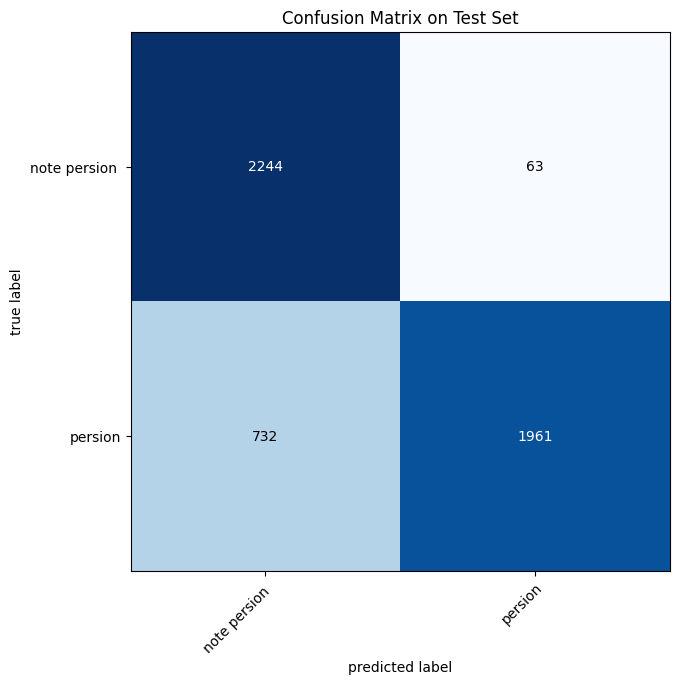

(0.31798563040792943, 0.8388671875)

In [ ]:
test_step(model = model_2_4th,
              dataloader = dataloader_val,
              loss_fn =loss_function_2_4th,
              show_plot_and_F1 = True )

In [ ]:
plot_random_samples(model=model_2_4th,
                    test_dataset=dataset_val,
                    num_samples=100,
                     show_images = 'all' # 'all' or 'TT' or 'FF' or 'FT' or 'TF' or 'all T' or 'all F'
                    )

## save model

In [ ]:
save_models_historyes(
    model_2_4th,
    model_2_4th_results,
    '/content/drive/MyDrive',
    'model_2_4th',
    )

Model saved :/content/drive/MyDrive/model_2_4th.pth
History saved : /content/drive/MyDrive/model_2_4th.csv


## model_2_5th

In [ ]:
!pip install torchsummary

In [ ]:
import torch
from torch import nn
from torchvision import models
from torchsummary import summary
class HumanPresenceSqueezeNet(nn.Module):
    def __init__(self,
                 pretrained=True,
                 weights=models.SqueezeNet1_1_Weights.DEFAULT,
                 freeze_features_up_to=10):
        super().__init__()
        # 1) بارگذاری backbone با API جدید weights
        base = models.squeezenet1_1(pretrained =pretrained)

        # 2) ساخت classifier جدید شامل Dropout → Conv2d → Conv2d → Flatten
        #    خروجی نهایی پس از Flatten می‌شود (B, 1)
        self.classifier = nn.Sequential(
            base.classifier[0],                             # Dropout
            nn.Conv2d(512, 1, kernel_size=1, stride=1),     # جایگزینی لایه
            nn.Conv2d(1, 1, kernel_size=13, stride=1),      # همانی که قبل داشتید
            nn.Flatten()                                     # <<< این‌جا flatten!
        )

        # 3) فریز کردن لایه‌های ابتدایی features
        self.features = base.features
        for p in list(self.features.parameters())[:freeze_features_up_to]:
            p.requires_grad = False

    def forward(self, x):
        x = self.features(x)      # (B,512,13,13)
        x = self.classifier(x)    # (B,1) پس از Flatten
        return x


# مثال و проверка summary
model = HumanPresenceSqueezeNet().to('cuda')

summary(model, (3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [ ]:
model_2_5th = load_model(HumanPresenceSqueezeNet,
                   '/content/drive/MyDrive/model_2_1th.pth',
                   device='cuda'
                   #,strict=False
                         )

## Create Folder data

In [ ]:
imm1 =  vdm.CutImage(image_dir = '/content/data/train2017',
              bake_dir = '/content/data_set/train_dataset/-1',
              ann_file = '/content/data/annotations/instances_train2017.json',
              category_id = 1,
              destination_dir = '/content/cut',
              cache_size= 10000000,
              memory_threshold = 95.0
              )

loading annotations into memory...
Done (t=20.95s)
creating index...
index created!


In [ ]:
# Cut box of images
imm1.create_cut_box_images( min_area=500, random_n = 1,random_size_box_cut=True)

Processing annotations:  51%|█████     | 133978/262465 [04:09<05:37, 380.49it/s]


 High memory usage 95.0%  , evicted /content/data/train2017/000000537548.jpg


Processing annotations: 100%|██████████| 262465/262465 [07:27<00:00, 587.17it/s]


In [ ]:
dir_path = "/content/cut/box_image"
display_random_images(dir_path, count=5)


In [ ]:
# Create bake grund
imm1.create_cut_box_bake()

Processing annotations:  12%|█▏        | 7773/64115 [01:40<12:39, 74.14it/s]

In [ ]:
dir_path = "/content/cut/bake_image_Not"
display_random_images(dir_path, count=5)


In [ ]:


move_images_to_folder(source_folder = '/content/data_set/train_dataset/1'
                      , destination_folder = '/content/train_dataset/1',
                      pasvand = None)

move_images_to_folder(source_folder = '/content/cut/bake_image_Not'
                      , destination_folder = '/content/train_dataset/-1',
                      pasvand = 'creat_bake')
tree_directory_images('/content/cut/box_image')

tree_directory_images('/content/train_dataset/')

/content/cut/box_image
├── box_image/
  ├── (186342 images)
  │   ├── Types: .jpg
/content/train_dataset/
├── -1/
  ├── (64115 images)
  │   ├── Types: .jpg
├── 1/
  ├── (64115 images)
  │   ├── Types: .jpg


In [ ]:
dir_folber_val = '/content/data_set/val_dataset'
dir_folber_train = '/content/train_dataset'
tree_directory_images(dir_folber_val)
tree_directory_images(dir_folber_train)

/content/data_set/val_dataset
├── val_dataset/
  ├── -1/
    ├── (2307 images)
    │   ├── Types: .jpg
  ├── 1/
    ├── (2693 images)
    │   ├── Types: .jpg
/content/train_dataset
├── train_dataset/
  ├── -1/
    ├── (64115 images)
    │   ├── Types: .jpg
  ├── 1/
    ├── (64115 images)
    │   ├── Types: .jpg


## dataset and dataloabe

In [ ]:
transform_val = transforms.Compose([
    #transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 2 ** 7
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_val = datasets.ImageFolder(root=dir_folber_val, transform=transform_val)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(dataset_val.class_to_idx)

{'-1': 0, '1': 1}


In [ ]:
from torchvision import datasets, transforms
# 4. آماده‌سازی داده‌ها
transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),   # تغییر اندازه به ورودی مدل
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])






# e.g. {'negative': 0, 'positive': 1}
# ImageFolder دو کلاس را 0 و 1 نگاشت می‌کند
dataset_train = datasets.ImageFolder(root=dir_folber_train, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

print(dataset_train.class_to_idx)

{'-1': 0, '1': 1}


## loss and optimazer

In [ ]:
# 3. تعریف تابع از دست دادن (Loss) و بهینه‌ساز
# استفاده از BCEWithLogitsLoss که برای خروجی باینری سیگموید استفاده می‌شود
loss_function_2_5th = nn.BCEWithLogitsLoss()  # این تابع از سیگموید به‌طور داخلی استفاده می‌کند
optimizer_2_5th = optim.Adam(model_2_5th.parameters(), lr=0.0001)



## trianing


In [ ]:
model_2_5th_results = train(model=model_2_5th,
                        train_dataloader=dataloader_train,
                        test_dataloader=dataloader_val,
                        optimizer=optimizer_2_5th,
                        loss_fn=loss_function_2_5th,
                        epochs = 5
                        , number_ep = 500 )

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 0
number_len : 500 / 1002| train_loss: 0.3499 | train_acc: 0.8328 | test_loss: 0.3620 | test_acc: 0.8363
number_len : 1000 / 1002| train_loss: 0.3052 | train_acc: 0.8522 | test_loss: 0.3668 | test_acc: 0.8492


 20%|██        | 1/5 [19:19<1:17:16, 1159.17s/it]

number_len : 1002 / 1002| train_loss: 0.2754 | train_acc: 0.8827 | test_loss: 0.3748 | test_acc: 0.8518
epoch : 1
number_len : 500 / 1002| train_loss: 0.2876 | train_acc: 0.8586 | test_loss: 0.3853 | test_acc: 0.8455
number_len : 1000 / 1002| train_loss: 0.2778 | train_acc: 0.8652 | test_loss: 0.4073 | test_acc: 0.8371


 40%|████      | 2/5 [37:18<55:37, 1112.34s/it]  

number_len : 1002 / 1002| train_loss: 0.2727 | train_acc: 0.8660 | test_loss: 0.4043 | test_acc: 0.8303
epoch : 2
number_len : 500 / 1002| train_loss: 0.2676 | train_acc: 0.8685 | test_loss: 0.4206 | test_acc: 0.8338
number_len : 1000 / 1002| train_loss: 0.2638 | train_acc: 0.8713 | test_loss: 0.3972 | test_acc: 0.8363


 60%|██████    | 3/5 [55:48<37:02, 1111.07s/it]

number_len : 1002 / 1002| train_loss: 0.2029 | train_acc: 0.8836 | test_loss: 0.4020 | test_acc: 0.8377
epoch : 3
number_len : 500 / 1002| train_loss: 0.2571 | train_acc: 0.8736 | test_loss: 0.4032 | test_acc: 0.8311
number_len : 1000 / 1002| train_loss: 0.2505 | train_acc: 0.8771 | test_loss: 0.4574 | test_acc: 0.8244


 80%|████████  | 4/5 [1:15:01<18:47, 1127.82s/it]

number_len : 1002 / 1002| train_loss: 0.2894 | train_acc: 0.8592 | test_loss: 0.4551 | test_acc: 0.8252
epoch : 4
number_len : 500 / 1002| train_loss: 0.2457 | train_acc: 0.8812 | test_loss: 0.4712 | test_acc: 0.8186
number_len : 1000 / 1002| train_loss: 0.2448 | train_acc: 0.8809 | test_loss: 0.4602 | test_acc: 0.8217


100%|██████████| 5/5 [1:34:59<00:00, 1139.82s/it]

number_len : 1002 / 1002| train_loss: 0.2381 | train_acc: 0.8611 | test_loss: 0.4650 | test_acc: 0.8225


## val model

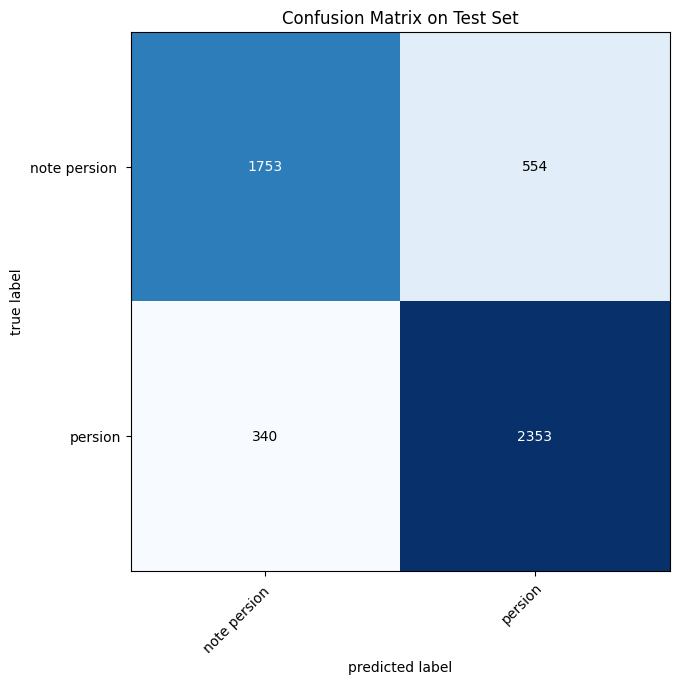

(0.4649882555007935, 0.8224609375)

In [ ]:
test_step(model = model_2_5th,
              dataloader = dataloader_val,
              loss_fn =loss_function_2_5th,
              show_plot_and_F1 = True )

In [ ]:
plot_random_samples(model=model_2_5th,
                    test_dataset=dataset_val,
                    num_samples=100,
                     show_images = 'all' # 'all' or 'TT' or 'FF' or 'FT' or 'TF' or 'all T' or 'all F'
                    )

## save model

In [ ]:
save_models_historyes(
    model_2_5th,
    model_2_5th_results,
    '/content/drive/MyDrive',
    'model_2_5th',
    )

Model saved :/content/drive/MyDrive/model_2_5th.pth
History saved : /content/drive/MyDrive/model_2_5th.csv
